### Якубов В.Ю. ДЗ_2 МАДМО
 - реализовать и отладить файнтюнинг крупной модели
 - Реализовать собственную модель
 - Реализовать дистилляцию из крупной модели в небольшую предобученную
 - Использовать Прунинг

In [102]:
import os
import shutil
from tqdm import tqdm
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from IPython.display import clear_output
from sklearn.metrics import classification_report

In [103]:
import matplotlib.pyplot as plt

In [104]:
import numpy as np

In [105]:
from sklearn.preprocessing import LabelEncoder

In [106]:
from sklearn.model_selection import train_test_split
import torchvision.models as models

In [107]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [108]:
from PIL import Image

In [109]:
from sklearn.utils import resample

In [110]:
if 'merged_data' not in os.listdir():
    os.makedirs('merged_data')
for i in tqdm(os.listdir('cancer_dataset/HAM10000_images_part_1')):
    shutil.copyfile(f'cancer_dataset/HAM10000_images_part_1/{i}', f'merged_data/{i}')
for i in tqdm(os.listdir('cancer_dataset/HAM10000_images_part_2')):
    shutil.copyfile(f'cancer_dataset/HAM10000_images_part_2/{i}', f'merged_data/{i}')

100%|██████████| 5015/5015 [00:03<00:00, 1468.46it/s]


In [111]:
dataframe = pd.read_csv('cancer_dataset/HAM10000_metadata.csv')

In [112]:
dataframe.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [113]:
le = LabelEncoder()
dataframe.dx = le.fit_transform(dataframe.dx)

In [114]:
data_train, data_test = train_test_split(dataframe, test_size=0.2)

In [115]:
maximum = data_train.groupby('dx').image_id.count().max()

In [116]:
maximum

5356

In [117]:
res = pd.DataFrame()
for i in data_train.dx.unique():
    res = res.append(resample(data_train[data_train.dx==i], n_samples=maximum))

C:\Users\Admin\AppData\Local\Temp\ipykernel_3408\2850963880.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(resample(data_train[data_train.dx==i], n_samples=maximum))
C:\Users\Admin\AppData\Local\Temp\ipykernel_3408\2850963880.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(resample(data_train[data_train.dx==i], n_samples=maximum))
C:\Users\Admin\AppData\Local\Temp\ipykernel_3408\2850963880.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(resample(data_train[data_train.dx==i], n_samples=maximum))
C:\Users\Admin\AppData\Local\Temp\ipykernel_3408\2850963880.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

In [118]:
res

,lesion_id,image_id,dx,dx_type,age,sex,localization
9863,HAM_0003633,ISIC_0030280,0,histo,70.0,male,upper extremity
9889,HAM_0005231,ISIC_0029043,0,histo,70.0,male,lower extremity
9776,HAM_0005389,ISIC_0024372,0,histo,70.0,male,lower extremity
10012,HAM_0002867,ISIC_0033536,0,histo,40.0,male,abdomen
9907,HAM_0005020,ISIC_0026626,0,histo,65.0,female,face
...,...,...,...,...,...,...,...
2461,HAM_0005560,ISIC_0027269,6,consensus,60.0,female,trunk
2421,HAM_0002788,ISIC_0027563,6,consensus,70.0,male,lower extremity
2418,HAM_0007150,ISIC_0028680,6,consensus,45.0,female,trunk
2408,HAM_0006406,ISIC_0026336,6,consensus,50.0,male,trunk


In [119]:
### Было бы полезно в случае, если
transform_probability = (1 - res.dx.value_counts()/len(res)) * 0.5
transform_probability_dict = transform_probability.to_dict()
transform_probability_dict

{0: 0.4285714285714286,
 2: 0.4285714285714286,
 4: 0.4285714285714286,
 5: 0.4285714285714286,
 1: 0.4285714285714286,
 3: 0.4285714285714286,
 6: 0.4285714285714286}

In [120]:
pos_weight = torch.tensor(((len(res)-res.dx.value_counts())/res.dx.value_counts()).reset_index().sort_values('index').dx)

In [121]:
X_train, X_test, y_train, y_test = list(res.image_id), list(data_test.image_id), list(res.dx), list(data_test.dx)

In [122]:
class CustomDataset(Dataset):
    def __init__(self, images_paths, image_labels, transform_probs, train=True):
        self.paths = images_paths
        self.labels = image_labels
        self.transform_probs = transform_probs
        self.train = train
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, item):
        image_name = self.paths[item]
        image_label = self.labels[item]
        image = Image.open(f'D:\mlp\MachineLearning\MADMO_2nd_homework\merged_data\{image_name}.jpg')
        transform_probability = self.transform_probs[image_label] if self.train else 0
        transformation = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((32, 32)),
                transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225)),
                transforms.RandomHorizontalFlip(p=transform_probability),
                transforms.RandomVerticalFlip(p=transform_probability)
            ]
        )
        image = transformation(image)
        return image, image_label


In [123]:
batch_size = 1024
train_dataset = CustomDataset(X_train, y_train, transform_probability_dict, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = CustomDataset(X_test, y_test, transform_probability_dict, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [124]:
vgg16 = models.vgg16(pretrained=True)

In [125]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for param in vgg16.parameters():
    param.requires_grad = False

vgg16.classifier[6] = torch.nn.Linear(4096, 7)
model = vgg16.to(device)

In [126]:
num_epochs = 5
lr = 1e-5
optimizer = Adam(vgg16.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=2, threshold=1e-3)

In [127]:
def loss_function(preds, true):
    loss = nn.CrossEntropyLoss()
    return loss(preds, true)

In [128]:
all_train_losses = []
all_test_losses = []

In [136]:
def train_model(model,
                num_epochs,
                loss_function,
                optimizer,
                scheduler,
                train_dataloader,
                test_dataloader):
    for epoch in range(num_epochs):
        train_loss = 0
        test_loss = 0
        model.train(True)
        print(f'epoch_number is {epoch}. Train')
        for (X, y) in tqdm(train_dataloader):
            model.zero_grad()
            X = X.to(device)
            y = y.to(device)
            preds = model.forward(X)
            loss = loss_function(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item() / (len(train_dataloader))
        model.train(False)
        model.eval()
        print(f'epoch_number is {epoch}. Test')
        for (X, y) in tqdm(test_dataloader):
            X = X.to(device)
            y = y.to(device)
            preds = model.forward(X)
            loss = loss_function(preds, y)
            test_loss += loss.detach().item() / (len(test_dataloader))
        scheduler.step(test_loss)
        clear_output()
        all_train_losses.append(train_loss)
        all_test_losses.append(test_loss)
        print('loss train', train_loss)
        print('loss test', test_loss)
        plt.figure(figsize = (10, 6))
        plt.plot(all_train_losses, label = 'Train loss', color = 'blue')
        plt.plot(all_test_losses, label = 'Val loss', color = 'orange')
        plt.legend()
        plt.ylabel('Loss')
        plt.grid()
        plt.show()

loss train 1.9837759468290546
loss test 1.681295394897461


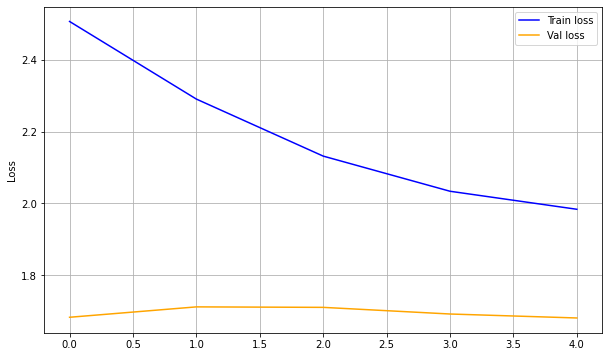

epoch_number is 1. Train


100%|██████████| 36/36 [03:46<00:00,  6.29s/it]


epoch_number is 1. Test


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_model(vgg16, num_epochs, loss_function, optimizer, scheduler, train_dataloader, test_dataloader)

In [ ]:
vgg16.train(False)
torch.save(vgg16.state_dict(), 'vgg16.pth')

In [ ]:
preds = []
real = []
for x, y in tqdm(test_dataloader):
    with torch.no_grad():
        preds.append(vgg16.forward(x.to(device)).detach().cpu().numpy())
        real.append(y.numpy())

In [ ]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [ ]:
final_preds.min()

In [ ]:
print(classification_report(real, final_preds))